# ID3

# 1.算法原理

通过递归，遍历每个特征，按该特征的各个特征值进行划分，计算其划分优化指数——熵（或信息增益）。然后选择熵最小（或信息增益最大）的特征，作为划分特征。该特征下的每个特征值生长出一棵子树，在每棵子树熵重复上述过程（但不选择已选特征），当满足某些条件时停止生长，子树化为叶结点，最终得到一棵完整的决策树。

停止生长条件如下：

（1）当没有新的特征可以选择且子树数据标签仍不是同类时，该子树化为叶结点，以其数据标签中数量最多的作为标签；

（2）当子树中没有数据时（这种情况发生在该子树父结点按该特征划分时，没有满足该特征值的数据），该子树化为叶结点，以其数据标签中数量最多的作为标签；

（3）当子树中的数据标签都属于同一类时，该子树化为叶结点，以该数据标签作为标签。

# 2.算法流程

## （1）决策树主函数

按照ID3算法规则，递归调⽤，⽣长出决策树的各个分⽀节点，并根据终⽌条件结束算法。

#### a.输入需要分类的数据集和类别标签。

#### b.挑选最佳特征指标，判定最优划分特征。

数据集合为$S$。

#### 熵（Entropy）：

在信息论中，若信源事件有$n$种取值：$U_1$，$\cdots$，$U_n$，对应于概率$p_1$，$\cdots$，$p_n$，且各事件彼此独立。$p$为取值为上述概率值的随机变量。则信源的信息熵为：$$Entropy(S)=E\left(\log\frac{1}{p}\right)=-\sum\limits_{i=1}^n p_i\log p_i$$上式中对数一般取2为底，即信息单位比特（bit）。

· 利用信息熵度量类别标签样本对样本整体的不确定性。设$S$是$s$个样本的集合，某个类别标签有$m$个不同类别$C_i$（$i=1,\cdots,m$）。设$S_i$是$C_i$中的样本集，则按该样本分类的信息熵为：$$Entropy(S_1,S_2,\cdots,S_m)=-\sum\limits_{i=1}^m p_i\log_2 p_i$$其中$p_i=\frac{|S_i|}{|S|}$是任意样本属于$C_i$的概率估计。

· 利用信息熵度量每种特征不同取值的不确定性。设特征$A$具有$N$个特征值$\{a_1,\cdots,a_N\}$，根据特征$A$划分的子集为$\{S^{1},\cdots,S^{N}\}$。设$S_i^j$是$C_i$类中特征$A$取值为$a_j$的样本集，则按$A$划分的信息熵为：$$Entropy(A)=\sum\limits_{j=1}^N\frac{|S_1^j|+|S_2^j|\cdots+|S_m^j|}{|S|}\cdot Entropy(S_1^j,S_2^j,\cdots,S_m^j)$$

#### 信息增益（Information Gain）：

信息增益是决策树上某分支整个数据集信息与当前节点信息熵的差值：$$IG(A)=Entropy(S_1,S_2,\cdots,S_m)-Entropy(A)$$

#### c.根据最优划分特征将数据集划分为多个子集。

#### d.每个子集作为树的子节点，生长出多个分支。

#### e.检验是否满足递归终止条件

#### f.将划分的各个新节点包含的数据集和类别标签作为输入，递归执行上述步骤

## （2）使用熵（或信息增益）计算数据集各特征列的最优划分列、划分值

## （3）根据最优特征的特征值生长出多个子树

# 3.代码实例

（1）ID3_Tree类

In [2]:
from numpy import *
import math
import copy
import cPickle as pickle

class ID3_Tree(object):
    def __init__(self):
        self.tree={}
        self.DataSet=[]
        self.labels=[]
        
    def loadDataSet(self,path,labels):
        recordlist=[]
        fp=open(path,"rb")
        content=fp.read()
        fp.close()
        rowlist=content.splitlines()
        recordlist=[row.split("\t"
                    ) for row in rowlist if row.strip()]
        self.DataSet=recordlist
        self.labels=labels
        
    def train(self):
        labels=copy.deepcopy(self.labels)
        self.tree=self.buildTree(self.DataSet,labels)
        
    def buildTree(self,DataSet,labels):
        # 抽取决策标签
        List=[data[-1] for data in DataSet] 
        # 若决策标签只有一种
        if List.count(List[0])==len(List):
            return List[0]
        # 若第一个标签的数据只有一个
        if len(DataSet[0])==1:
            return self.Max(List)
        
        BestFeature=self.getBestFeature(DataSet)
        BestFeatureLabels=labels[BestFeature]
        tree={BestFeatureLabels:{}}
        del(labels[BestFeature])
        
        UniqueValue=set(
            [data[BestFeature] for data in DataSet])
        for value in UniqueValue:
            SubLabels=labels[:]
            SplitDataSet=self.splitDataSet(
                DataSet,BestFeature,value)
            SubTree=self.buildTree(
                SplitDataSet,SubLabels)
            tree[BestFeatureLabels][value]=SubTree
        return tree
        
    def Max(self,List):
        items=dict([(List.count(i),i) for i in List])
        return items[max(items.keys())]
    
    def getBestFeature(self,DataSet):
        NumFeatures=len(DataSet[0])-1
        BaseEntropy=self.computeEntropy(DataSet)
        BestInfoGain=0.0
        BestFeature=-1;
        
        for i in xrange(NumFeatures):
            UniqueValues=set(
                [data[i] for data in DataSet])
            NewEntropy=0.0
            for value in UniqueValues:
                SubDataSet=self.splitDataSet(
                    DataSet,i,value)
                prob=len(SubDataSet)/float(
                    len(DataSet))
                NewEntropy+=prob*self.computeEntropy(
                    SubDataSet)
            InfoGain=BaseEntropy-NewEntropy
            if InfoGain>BestInfoGain:
                BestInfoGain=InfoGain
                BestFeature=i
        return BestFeature
    
    def computeEntropy(self,DataSet):
        datalen=float(len(DataSet))
        List=[data[-1] for data in DataSet]
        
        items=dict([(i,List.count(i)) for i in List])
        InfoEntropy=0.0
        for key in items:
            prob=float(items[key])/datalen
            InfoEntropy-=prob*math.log(prob,2)
        return InfoEntropy
    
    def splitDataSet(self,DataSet,axis,value):
        List=[]
        for FeatureVector in DataSet:
            if FeatureVector[axis]==value:
                RestFeatureVector=FeatureVector[:axis]
                RestFeatureVector.extend(
                    FeatureVector[axis+1:])
                List.append(RestFeatureVector)
        return List
        
    # 保存，读取决策树
    def saveTree(self,inputTree,filename):
        f=open(filename,"w")
        pickle.dump(inputTree,f)
        f.close()
        
    def getTree(self,filename):
        f=open(filename)
        return pickle.load(f)
        
    # 分类器
    def predict(self,inputTree,labels,testVector):
        root=inputTree.keys()[0]
        secondDict=inputTree[root]
        Index=labels.index(root)
        key=testVector[Index]
        value=secondDict[key]
        if isinstance(value,dict):
            classLabel=self.predict(
                value,labels,testVector)
        else:
            classLabel=value
        return classLabel

（2）主函数

The Decision Tree by ID3:
{'age': {'1': 'yes', '0': {'student': {'1': 'yes', '0': 'no'}}, '2': {'credit': {'1': 'no', '0': 'yes'}}}} 

predict: no 

Tree Plot:



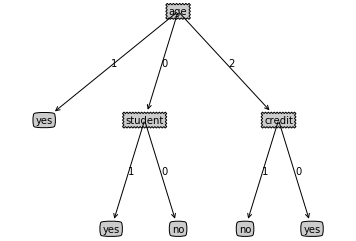

In [8]:
labels=["age","reveue","student","credit"]
dtree=ID3_Tree()
dtree.loadDataSet("dataset.dat",labels)
dtree.train()
print "The Decision Tree by ID3:"
print dtree.tree,"\n"

vector=['0','1','0','0']
print "predict:"
print dtree.predict(dtree.tree,labels,vector),"\n"

import treePlotter as tp
print "Tree Plot:\n"
tp.createPlot(dtree.tree)